In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d

In [2]:
TIME_STEP = 1/1000

In [3]:
class Plant:
    
    def __init__(self, noise_scale=0, noise_decay=0, noise_momentum=0.5):
        self.__x = 0
        self.__y = 0
        self.__z = 0
        self.__vx = 0
        self.__vy = 0
        self.__vz = 0
        self.__noise_scale = noise_scale
        self.__noise_decay = noise_decay
        self.__noise_momentum = noise_momentum
        self.noise = np.zeros(3)
    
    def step(self, ax, ay, az):
        noise = np.random.randn(3) * self.__noise_scale
        self.noise = \
            self.__noise_momentum*self.noise + \
            (1-self.__noise_momentum)*noise
        self.noise *= 1-self.__noise_decay
        ax += self.noise[0]
        ay += self.noise[1]
        az += self.noise[2]
        self.__x += self.__vx*TIME_STEP + 0.5*ax*TIME_STEP**2
        self.__y += self.__vy*TIME_STEP + 0.5*ay*TIME_STEP**2
        self.__z += self.__vz*TIME_STEP + 0.5*az*TIME_STEP**2
        self.__vx += ax*TIME_STEP
        self.__vy += ay*TIME_STEP
        self.__vz += az*TIME_STEP
        return self.__x, self.__y, self.__z

In [4]:
class PIDController:
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.disable_integral = False
        self.ierr = 0
        self.__prev_err = 0
    
    def step(self, measured, desired):
        err = desired - measured
        self.ierr = 0 if self.disable_integral else self.ierr + err*TIME_STEP
        derr = (err-self.__prev_err)/TIME_STEP
        self.__prev_err = err
        return self.Kp*err + self.Ki*self.ierr + self.Kd*derr

In [5]:
class Target:
    
    def __init__(self, scale=1, momentum=0.5):
        self.__plant = Plant(noise_scale=0)
        self.__scale = scale
        self.__momentum = momentum
        self.__a = np.zeros((3,))
    
    def step(self):
        self.__a = self.__a*self.__momentum + \
            (1-self.__momentum)*np.random.randn(3)
        return self.__plant.step(*self.__a*self.__scale)

final noise -4.842184711122352 0.275373277558691 1.1889907512807252
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.02611850846252395 -0.043354267929239576 0.10698889234004483


<IPython.core.display.Javascript object>


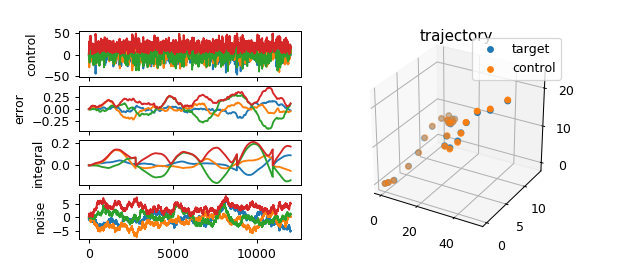

In [6]:
Kp,Ki,Kd = 10,100,35
control_max = 50
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
pid_x, pid_y, pid_z = [PIDController(Kp,Ki,Kd) for _ in range(3)]
x,y,z = plant.step(0,0,0)
T, Y, C, E, I, N = [[] for _ in range(6)]
for t in range(12000):
    tx,ty,tz = target.step()
    cx = pid_x.step(x,tx)
    cy = pid_y.step(y,ty)
    cz = pid_z.step(z,tz)
    clen = np.linalg.norm((cx,cy,cz))
    pid_x.disable_integral = \
    pid_y.disable_integral = \
    pid_z.disable_integral = clen > control_max
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((tx-x,ty-y,tz-z,np.linalg.norm((tx-x,ty-y,tz-z))))
    I.append((pid_x.ierr,pid_y.ierr,pid_z.ierr,np.linalg.norm((pid_x.ierr,pid_y.ierr,pid_z.ierr))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()

In [7]:
import keras
import keras.backend as K

Using TensorFlow backend.


In [52]:
class PIDCell(keras.layers.Layer):
    
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        super(PIDCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.built = True
    
    def call(self, inputs, states):
        dt, err, Kp, Ki, Kd, reset_integral = \
            inputs[:,0:1],inputs[:,1:self.units+1], \
            inputs[:,self.units+1:self.units+2],inputs[:,self.units+2:self.units+3], \
            inputs[:,self.units+3:self.units+4],inputs[:,self.units+4:self.units+5]
        perr, ierr = states
        ierr_gate = 1-K.sigmoid(reset_integral)
        ierr = ierr_gate*(ierr+err*dt)
        derr = (err-perr)/dt
        perr = err
        return K.softplus(Kp)*err + K.softplus(Ki)*ierr + K.softplus(Kd)*derr, [perr, ierr]

In [53]:
X_input_dt = keras.layers.Input((None, 1), batch_shape=(1,1,1))
X_input_err = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X_input_tar = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err,X_input_tar])
X = keras.layers.LSTM(64, stateful=True, return_sequences=True)(X)
X_Kp = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_Ki = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_Kd = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_reset_integral = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X = keras.layers.Concatenate()([X_input_dt,X_input_err,X_Kp,X_Ki,X_Kd,X_reset_integral])
X_pid,_,X_ierr = keras.layers.RNN(PIDCell(3), stateful=True, return_sequences=True, return_state=True)(X)
X_Kp = keras.layers.Lambda(lambda x: K.softplus(x))(X_Kp)
X_Ki = keras.layers.Lambda(lambda x: K.softplus(x))(X_Ki)
X_Kd = keras.layers.Lambda(lambda x: K.softplus(x))(X_Kd)
X_reset_integral = keras.layers.Lambda(lambda x: 1-K.sigmoid(x))(X_reset_integral)
M_control = keras.Model([X_input_dt,X_input_err,X_input_tar], X_pid)
M_control.compile('adam', 'mse')
M_control_freeze = keras.Model(
    [X_input_dt,X_input_err,X_input_tar],
    [X_pid,X_ierr,X_Kp,X_Ki,X_Kd,X_reset_integral])
M_control_freeze.trainable = False
M_control_freeze.compile('adam', 'mse')
M_control.summary()

X_input_ctl = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err,X_input_tar,X_input_ctl])
X = keras.layers.LSTM(64, stateful=True, return_sequences=True)(X)
X = keras.layers.TimeDistributed(keras.layers.Dense(3, kernel_initializer='he_normal'))(X)
M_plant = keras.Model([X_input_err,X_input_tar,X_input_ctl], X)
M_plant.compile('adam', 'mse')
M_plant_freeze = keras.Model([X_input_err,X_input_tar,X_input_ctl], X)
M_plant_freeze.trainable = False
M_plant_freeze.compile('adam', 'mse')
M_plant.summary()

X = M_control([X_input_dt,X_input_err,X_input_tar])
X = M_plant_freeze([X_input_err,X_input_tar,X])
M_train = keras.Model([X_input_dt,X_input_err,X_input_tar], X)
M_train.compile('adam', 'mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (1, 1, 3)            0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           (1, 1, 3)            0                                            
__________________________________________________________________________________________________
concatenate_32 (Concatenate)    (1, 1, 6)            0           input_47[0][0]                   
                                                                 input_48[0][0]                   
__________________________________________________________________________________________________
lstm_29 (LSTM)                  (1, 1, 64)           18176       concatenate_32[0][0]             
__________

final noise 0.5258964788424229 1.083603647288388 -0.6184133752774572
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -2.1123083588926193 -1.5985722862996443 0.07089325089702925


<IPython.core.display.Javascript object>


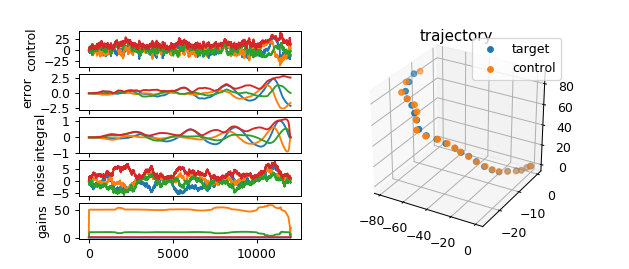

plant model loss [0.009483360685408115]
trainning model loss [1.2226067781448364]
final noise -0.5890862655840504 0.28216940403295254 -0.12893428445710176
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -3.9537010247774447 -0.815693842141819 2.764092855351443


<IPython.core.display.Javascript object>


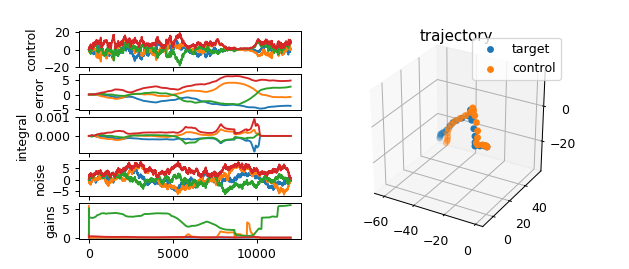

plant model loss [0.00035584691795520484]
trainning model loss [5.203282833099365]
final noise -0.42733517289827383 -3.0444745799959385 -1.1872639568919405
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -9.974618930746129 -7.437035943909002 7.5878629312405454


<IPython.core.display.Javascript object>


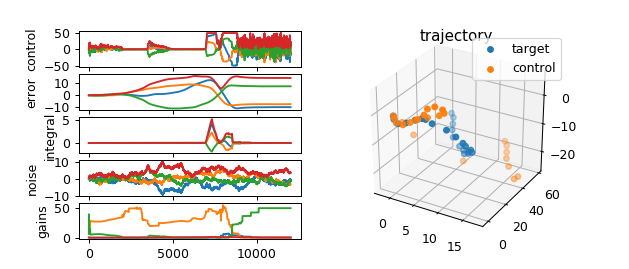

plant model loss [0.0004084751708433032]
trainning model loss [29.3588809967041]
final noise 4.212305591817754 2.0092779569807635 1.0867086778480433
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.061698534787588244 -1.533031651065059 -1.0291786411809234


<IPython.core.display.Javascript object>


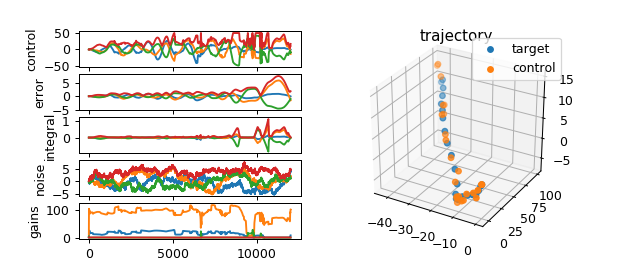

plant model loss [0.000180354094482027]
trainning model loss [0.41849684715270996]
final noise 0.7233337741746045 -3.7157666170257113 -1.0103187611859676
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.8191580288517812 0.06369968207143017 -0.5997104098812827


<IPython.core.display.Javascript object>


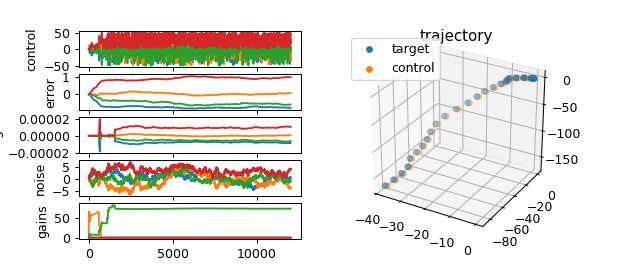

plant model loss [0.00018241147336084396]
trainning model loss [0.32993748784065247]
final noise 1.6702221122017176 2.5952733733130313 3.3523823716434773
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -8.981160769278702 13.261686704114126 -18.627920940903564


<IPython.core.display.Javascript object>


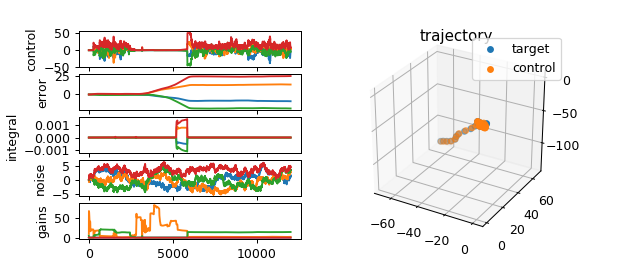

plant model loss [4.533612809609622e-07]
trainning model loss [36.22704315185547]
final noise -2.4488920649018238 -1.043652455412395 -1.5731069901131334
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 0.8566036844466112 -8.239106926789034 -5.266272278870318


<IPython.core.display.Javascript object>


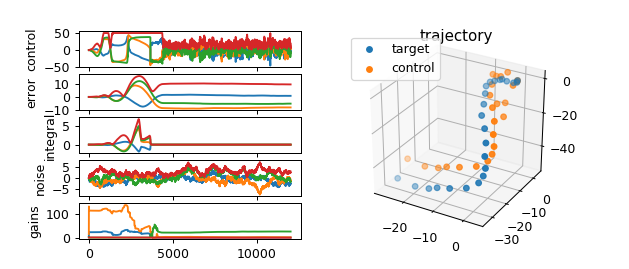

plant model loss [0.0031939384061843157]
trainning model loss [4.0084309577941895]
final noise -0.5241155755275472 1.54246905632879 2.8460779644298597
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.629366135067869 5.39820177434774 -9.687737994603296


<IPython.core.display.Javascript object>


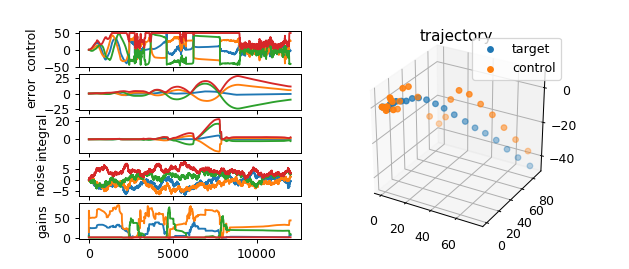

plant model loss [0.0010575741762295365]
trainning model loss [26.11473846435547]
final noise 3.26117768426287 0.7237811049386125 0.11849161447919046
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -5.282079902350205 0.1500293333382925 -0.2208190813054216


<IPython.core.display.Javascript object>


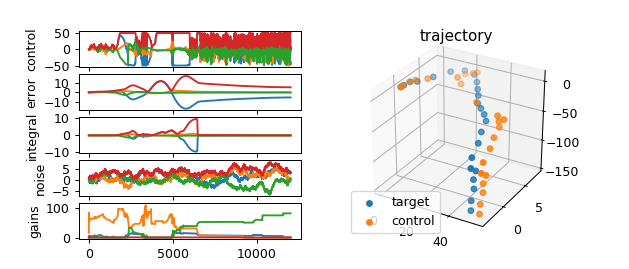

plant model loss [0.02358418144285679]
trainning model loss [7.786998748779297]
final noise -3.1270937347140335 -1.1464879018860132 0.3427432069394265
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 5.806690943781703 -5.865311732458142 -1.0004411458456843


<IPython.core.display.Javascript object>


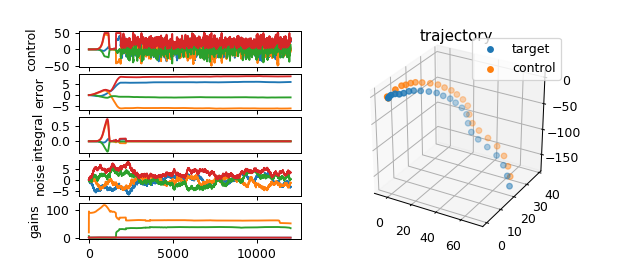

plant model loss [0.004061709623783827]
trainning model loss [3.9732401371002197]
final noise 0.9288243771150317 -1.4226086102779905 1.7971324147538354
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -4.238208174004129 -3.116407581969341 -1.585613468587411


<IPython.core.display.Javascript object>


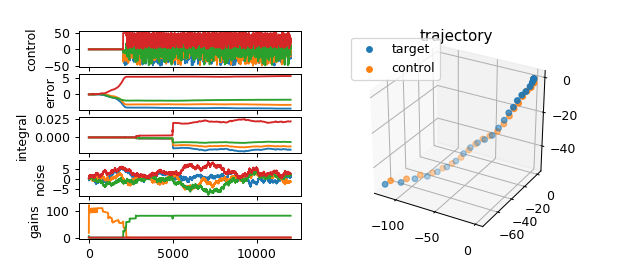

plant model loss [0.0008151685469783843]
trainning model loss [6.028560638427734]
final noise -1.8439298935502835 0.5375947458987438 1.3231429367831182
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -5.727345610947019 9.982804396169925 -5.636095501295838


<IPython.core.display.Javascript object>


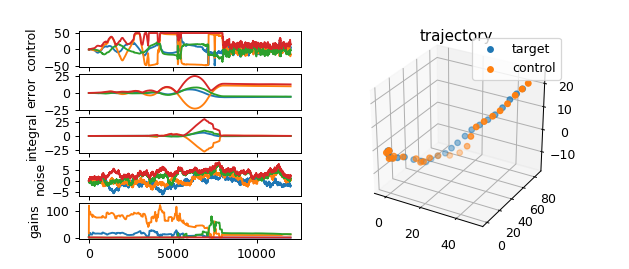

plant model loss [0.00579182431101799]
trainning model loss [34.848445892333984]
final noise 7.3684031804034875 0.9209752916111128 -4.3295224664206975
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.02383356215513288 -0.3228783063556335 -0.08705484084141446


<IPython.core.display.Javascript object>


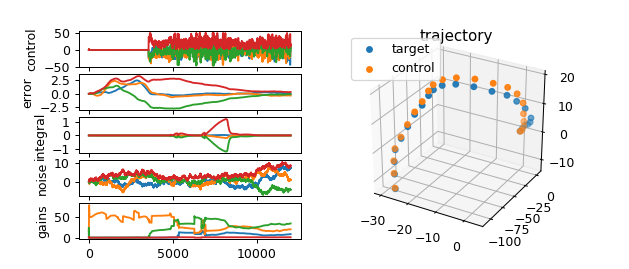

plant model loss [0.0031334476079791784]
trainning model loss [0.03302514925599098]
final noise -0.1133170461359588 0.823325881671149 1.7575847815168841
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -0.2628775817962392 -0.1714945283428948 -0.16685492763408405


<IPython.core.display.Javascript object>


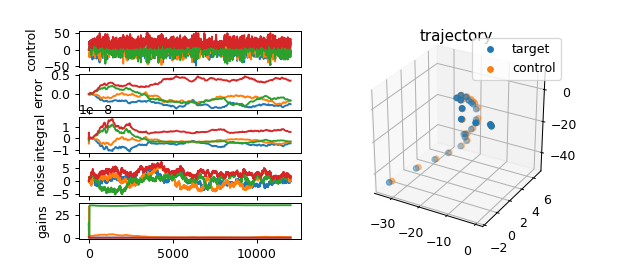

plant model loss [0.004536208231002092]
trainning model loss [0.0395674966275692]
final noise -5.595347788114999 -1.4222870165925627 -2.160891884006857
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -2.77593352446497 2.1138980179172506 -3.2231038383888873


<IPython.core.display.Javascript object>


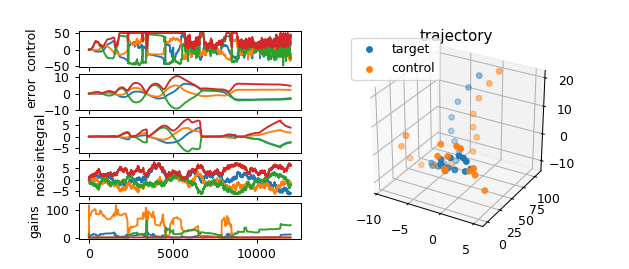

plant model loss [0.0008416077471338212]
trainning model loss [1.3752965927124023]
final noise -1.6797488727289631 2.1781622146732085 -2.147116933542823
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -3.8405198376972915 10.446078832823474 19.718541483915924


<IPython.core.display.Javascript object>


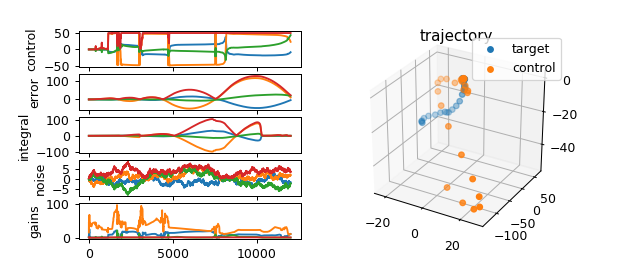

plant model loss [0.03470056876540184]
trainning model loss [14.738250732421875]
final noise -3.6509967468802444 0.07130096041885137 -2.919483300254939
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 1.8706869211759383 -1.1729908143444163 -5.094196253641826


<IPython.core.display.Javascript object>


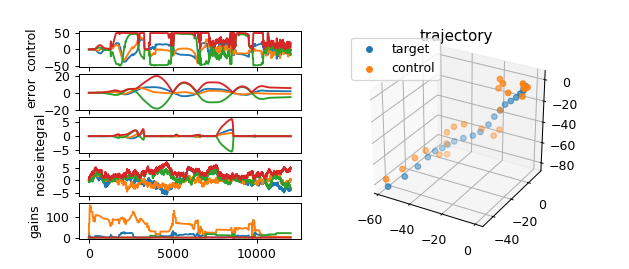

plant model loss [0.4763588011264801]
trainning model loss [11.22020435333252]
final noise 1.7871130391710761 3.9318571719393183 -3.450086462481785
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 0.27250040828314503 0.09503046082978273 2.295255781994854


<IPython.core.display.Javascript object>


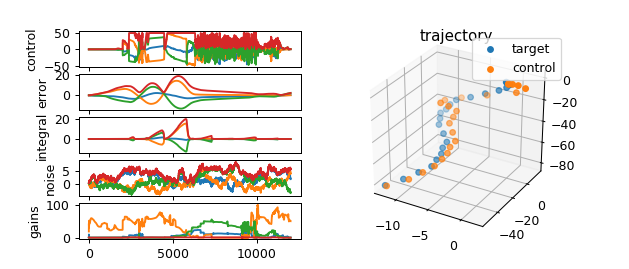

plant model loss [7.410748821712332e-06]
trainning model loss [0.148515522480011]
final noise -0.5878230218516172 -0.945079969118618 0.12664614603957966
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 127.46436627795495 -15.447039763765467 43.42155050348616


<IPython.core.display.Javascript object>


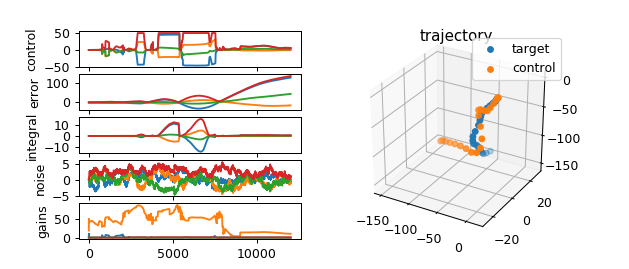

plant model loss [0.009775449521839619]
trainning model loss [29.841550827026367]
final noise 0.03314178208266998 3.1446927051235716 -0.03722123445124951
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 63.06882477239775 14.952300208691028 -113.78825296066451


<IPython.core.display.Javascript object>


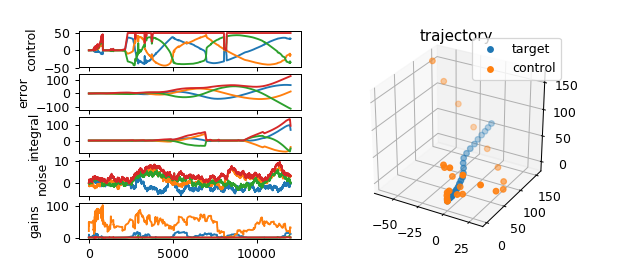

plant model loss [57.19438171386719]
trainning model loss [539.0266723632812]
final noise 0.2028955819612272 0.6648237719608663 5.429044584052283
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 0.11805512218091962 -13.376282110971076 -12.336102836695147


/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


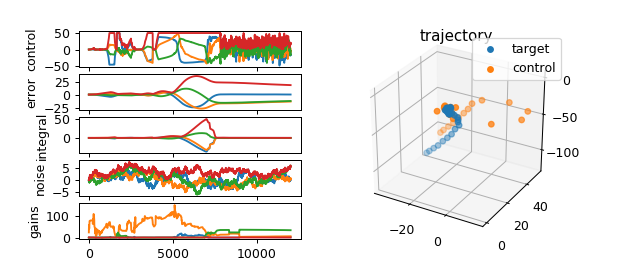

plant model loss [0.19315920770168304]
trainning model loss [119.5592269897461]
final noise -1.3306410224160767 2.4905053029932716 -0.7411966479260232
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -63.605751169880264 -120.039626112871 -67.73721058313522


<IPython.core.display.Javascript object>


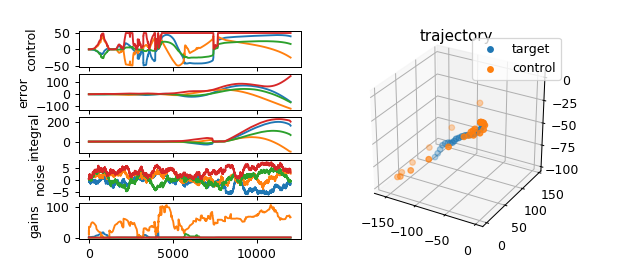

plant model loss [437.6877746582031]
trainning model loss [198.2694091796875]
final noise -0.785937232362127 -1.2258198394766944 -2.618112568205389
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -56.81485015966677 45.10694891246802 -3.592360461988843


<IPython.core.display.Javascript object>


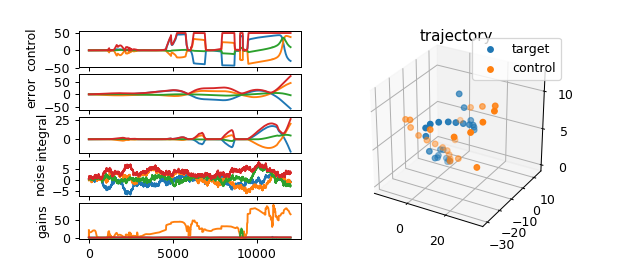

plant model loss [23.11566162109375]
trainning model loss [195.6338653564453]
final noise -0.6880593857447661 3.5817870187586114 2.0749523223645787
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 17.856118881369046 60.81416369277375 19.08610239774326


<IPython.core.display.Javascript object>


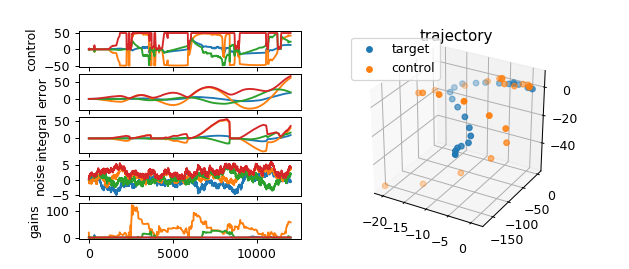

plant model loss [18.26056671142578]
trainning model loss [183.103515625]
final noise 1.8524543161416407 4.106327868819085 0.4385316666645453
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 14.111264230393978 6.322138423235215 10.589052172777485


<IPython.core.display.Javascript object>


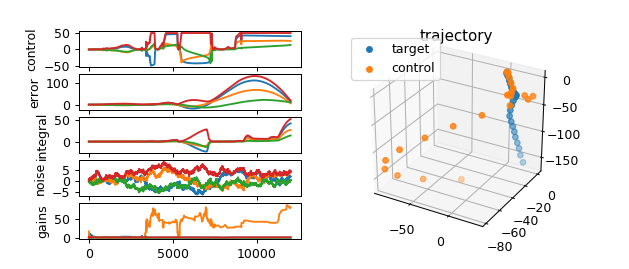

plant model loss [3.707376480102539]
trainning model loss [47.43197250366211]
final noise -0.8311089850746836 -0.5075648343323276 0.05030849129431614
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 10.539808174145264 31.984983894364902 28.193770216902195


<IPython.core.display.Javascript object>


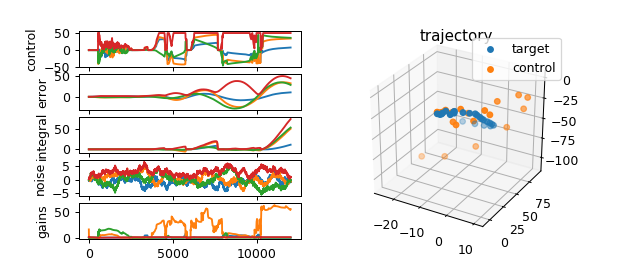

plant model loss [0.237967386841774]
trainning model loss [179.0802001953125]
final noise 0.5969074389943583 2.1258843038283595 1.8918482173885622
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -32.56582075229609 58.37840935427738 13.784134014917697


<IPython.core.display.Javascript object>


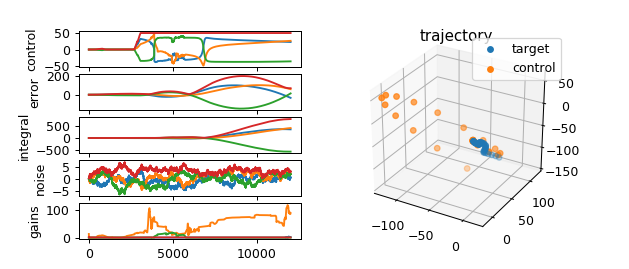

plant model loss [0.47843194007873535]
trainning model loss [362.40185546875]
final noise -1.1649171218488816 -1.1234358707661616 -0.06504854019789441
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 59.75925718327282 24.17351636325004 2.639498271738331


<IPython.core.display.Javascript object>


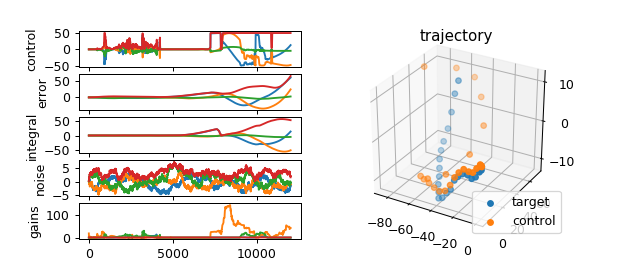

plant model loss [0.06867985427379608]
trainning model loss [118.0248031616211]
final noise -5.491530556583546 -4.326589080646727 0.8981696301193318
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err -42.11430100637933 9.896002362946447 -102.35568188277603


<IPython.core.display.Javascript object>


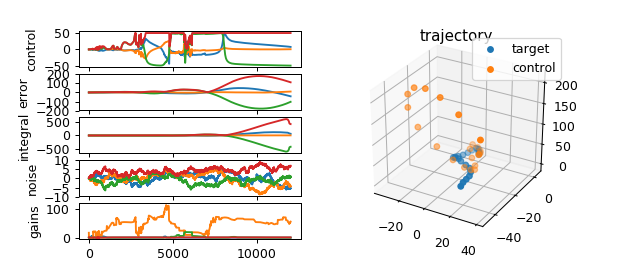

plant model loss [21.770849227905273]
trainning model loss [100.8741455078125]
final noise -2.0951103620146116 -1.0301517349417448 1.9359414249937397
final ierr 0.08956843714725214 -0.049119879876032925 -0.1320456802586795
final err 203.01857115130193 233.77503952317397 32.074297260582796


<IPython.core.display.Javascript object>


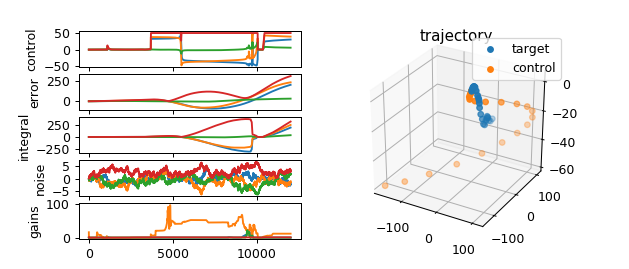

plant model loss [1604.3116455078125]
trainning model loss [548.9321899414062]
1min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 30 loops each)


In [56]:
%%timeit -n 30 -r 1

control_max = 50
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
x,y,z = plant.step(0,0,0)
ex,ey,ez = 0,0,0
T, Y, C, E, I, N, G = [[] for _ in range(7)]
M_control_freeze.reset_states()
for t in range(12000):
    tx,ty,tz = target.step()
    ctl,ierr,Kp,Ki,Kd,ierr_gate = M_control_freeze.predict([
        np.array([[[TIME_STEP]]]),
        np.array([[[ex,ey,ez]]]),
        np.array([[[tx,ty,tz]]])-np.array([[[x,y,z]]])])
    cx,cy,cz = ctl[0,0]
    iex,iey,iez = ierr[0]
    clen = np.linalg.norm((cx,cy,cz))
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    ex,ey,ez = tx-x,ty-y,tz-z
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((ex,ey,ez,np.linalg.norm((ex,ey,ez))))
    I.append((iex,iey,iez,np.linalg.norm((iex,iey,iez))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
    G.append((Kp[0,0,0],Ki[0,0,0],Kd[0,0,0],ierr_gate[0,0,0]))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', ex, ey, ez)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(521); plt.ylabel('control'); plt.plot(C)
plt.subplot(523); plt.ylabel('error'); plt.plot(E)
plt.subplot(525); plt.ylabel('integral'); plt.plot(I)
plt.subplot(527); plt.ylabel('noise'); plt.plot(N)
plt.subplot(529); plt.ylabel('gains'); plt.plot(G)
plt.show()

M_plant.reset_states()
for e,t,y,c,l in zip(E[:-1], T[1:], Y[:-1], C[1:], E[1:]):
    history = M_plant.fit(
        [np.array([[e[:3]]]),np.array([[t[:3]]])-np.array([[y[:3]]]),np.array([[c[:3]]])],
        np.array([[l[:3]]]), batch_size=1, shuffle=False, verbose=0)
print('plant model loss', history.history['loss'])

M_train.reset_states()
for e,t,y in zip(E[:-1], T[1:], Y[:-1]):
    history = M_train.fit(
        [np.array([[[TIME_STEP]]]),np.array([[e[:3]]]),np.array([[t[:3]]])-np.array([[y[:3]]])],
        np.array([[[0,0,0]]]), batch_size=1, shuffle=False, verbose=0)
print('trainning model loss', history.history['loss'])